In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import evaluate
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Charger les données
df = pd.read_csv('./data/cleaned_combined_dataset.csv')

# Assurez-vous que les colonnes sont correctement nommées
assert 'text' in df.columns, "La colonne 'text' est manquante dans le DataFrame"
assert 'label' in df.columns, "La colonne 'label' est manquante dans le DataFrame"

# Convertir les étiquettes en entiers (0 pour non_hateful, 1 pour hateful)
df['label'] = df['label'].map({'non_hateful': 0, 'hateful': 1})

# Diviser le dataset en ensembles d'entraînement et de validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [4]:
# Charger le tokenizer et le modèle
model_name = "Poulpidot/distilcamenbert-french-hate-speech"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [5]:
#Prétraiter les données
def preprocess_function(examples):
    if isinstance(examples['text'], list):
        examples['text'] = [str(text) for text in examples['text']]
    return tokenizer(examples['text'], truncation=True, padding=True)

In [6]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)

# Créer un DataCollatorWithPadding pour gérer le padding dynamique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/10717 [00:00<?, ? examples/s]

Map:   0%|          | 0/2680 [00:00<?, ? examples/s]

In [7]:
# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',          # Sortie des résultats
    num_train_epochs=3,              # Nombre d'époques
    per_device_train_batch_size=16,  # Taille du batch d'entraînement
    per_device_eval_batch_size=16,   # Taille du batch d'évaluation
    warmup_steps=500,                # Nombre d'étapes de warmup
    weight_decay=0.01,               # Facteur de déclin de poids
    logging_dir='./logs',            # Répertoire pour les logs
    logging_steps=10,
    eval_strategy="epoch",      # Évaluer à la fin de chaque époque
    use_cpu=True
)

# Charger la métrique d'évaluation
metric = evaluate.load("accuracy")

In [8]:
# Définir la fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    predictions = torch.argmax(logits_tensor, dim=-1)
    return metric.compute(predictions=predictions, references=labels)

In [9]:
# Initialiser le Trainer
trainer = Trainer(
    model=model,                         # Le modèle à entraîner
    args=training_args,                  # Arguments d'entraînement
    train_dataset=tokenized_train_dataset,     # Le dataset d'entraînement
    eval_dataset=tokenized_val_dataset, # Le dataset de validation
    data_collator=data_collator,
    compute_metrics=compute_metrics       # Fonction de calcul des métriques
)

In [10]:
# Entraîner le modèle
trainer.train()

# Évaluer le modèle sur le jeu de validation
eval_result = trainer.evaluate(eval_dataset=tokenized_val_dataset)
print(f"Evaluation results: {eval_result}")

  0%|          | 0/2010 [00:00<?, ?it/s]

{'loss': 0.5696, 'grad_norm': 4.45645809173584, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 0.6303, 'grad_norm': 6.671645641326904, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.03}
{'loss': 0.6185, 'grad_norm': 5.5814595222473145, 'learning_rate': 3e-06, 'epoch': 0.04}
{'loss': 0.6089, 'grad_norm': 4.977560043334961, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.06}
{'loss': 0.6003, 'grad_norm': 5.896027565002441, 'learning_rate': 5e-06, 'epoch': 0.07}
{'loss': 0.6373, 'grad_norm': 4.689947128295898, 'learning_rate': 6e-06, 'epoch': 0.09}
{'loss': 0.5625, 'grad_norm': 5.484979629516602, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.1}
{'loss': 0.5743, 'grad_norm': 4.163605690002441, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.12}
{'loss': 0.6002, 'grad_norm': 4.393767356872559, 'learning_rate': 9e-06, 'epoch': 0.13}
{'loss': 0.5586, 'grad_norm': 5.1933794021606445, 'learning_rate': 1e-05, 'epoch': 0.15}
{'loss': 0.5636, 'grad_norm': 5.246206

  0%|          | 0/168 [00:00<?, ?it/s]

{'eval_loss': 0.47057026624679565, 'eval_accuracy': 0.7742537313432836, 'eval_runtime': 39.4663, 'eval_samples_per_second': 67.906, 'eval_steps_per_second': 4.257, 'epoch': 1.0}
{'loss': 0.3697, 'grad_norm': 5.038154125213623, 'learning_rate': 4.403973509933775e-05, 'epoch': 1.01}
{'loss': 0.3425, 'grad_norm': 9.897286415100098, 'learning_rate': 4.370860927152318e-05, 'epoch': 1.03}
{'loss': 0.4111, 'grad_norm': 3.670175790786743, 'learning_rate': 4.337748344370861e-05, 'epoch': 1.04}
{'loss': 0.478, 'grad_norm': 5.431910514831543, 'learning_rate': 4.304635761589404e-05, 'epoch': 1.06}
{'loss': 0.2817, 'grad_norm': 6.352431297302246, 'learning_rate': 4.271523178807947e-05, 'epoch': 1.07}
{'loss': 0.3592, 'grad_norm': 8.20695686340332, 'learning_rate': 4.23841059602649e-05, 'epoch': 1.09}
{'loss': 0.4989, 'grad_norm': 5.773820400238037, 'learning_rate': 4.205298013245033e-05, 'epoch': 1.1}
{'loss': 0.3921, 'grad_norm': 5.409891128540039, 'learning_rate': 4.1721854304635764e-05, 'epoch':

  0%|          | 0/168 [00:00<?, ?it/s]

{'eval_loss': 0.4926498234272003, 'eval_accuracy': 0.7776119402985074, 'eval_runtime': 38.7065, 'eval_samples_per_second': 69.239, 'eval_steps_per_second': 4.34, 'epoch': 2.0}
{'loss': 0.2796, 'grad_norm': 5.523646354675293, 'learning_rate': 2.185430463576159e-05, 'epoch': 2.01}
{'loss': 0.2423, 'grad_norm': 4.1558098793029785, 'learning_rate': 2.152317880794702e-05, 'epoch': 2.03}
{'loss': 0.31, 'grad_norm': 1.6968073844909668, 'learning_rate': 2.119205298013245e-05, 'epoch': 2.04}
{'loss': 0.2746, 'grad_norm': 5.409918785095215, 'learning_rate': 2.0860927152317882e-05, 'epoch': 2.06}
{'loss': 0.1988, 'grad_norm': 3.407233238220215, 'learning_rate': 2.052980132450331e-05, 'epoch': 2.07}
{'loss': 0.3412, 'grad_norm': 17.77273941040039, 'learning_rate': 2.0198675496688745e-05, 'epoch': 2.09}
{'loss': 0.2248, 'grad_norm': 8.14523696899414, 'learning_rate': 1.9867549668874173e-05, 'epoch': 2.1}
{'loss': 0.2457, 'grad_norm': 3.087540626525879, 'learning_rate': 1.9536423841059604e-05, 'epoc

  0%|          | 0/168 [00:00<?, ?it/s]

{'eval_loss': 0.5832852721214294, 'eval_accuracy': 0.780223880597015, 'eval_runtime': 39.2157, 'eval_samples_per_second': 68.34, 'eval_steps_per_second': 4.284, 'epoch': 3.0}
{'train_runtime': 2534.728, 'train_samples_per_second': 12.684, 'train_steps_per_second': 0.793, 'train_loss': 0.3909824792425431, 'epoch': 3.0}


  0%|          | 0/168 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.5832852721214294, 'eval_accuracy': 0.780223880597015, 'eval_runtime': 38.8909, 'eval_samples_per_second': 68.911, 'eval_steps_per_second': 4.32, 'epoch': 3.0}


  0%|          | 0/168 [00:00<?, ?it/s]

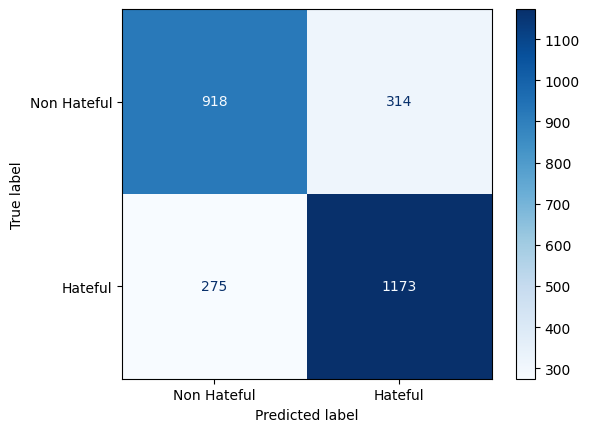

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1232
           1       0.79      0.81      0.80      1448

    accuracy                           0.78      2680
   macro avg       0.78      0.78      0.78      2680
weighted avg       0.78      0.78      0.78      2680

Accuracy Score: 0.780223880597015


In [11]:
# Obtenir les prédictions
predictions = trainer.predict(tokenized_val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Calculer la matrice de confusion
cm = confusion_matrix(val_df['label'], preds)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Hateful', 'Hateful'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Afficher le rapport de classification
print("Classification Report:\n", classification_report(val_df['label'], preds))
print("Accuracy Score:", accuracy_score(val_df['label'], preds))

In [12]:
# Enregistrer le modèle et le tokenizer
model.save_pretrained('./models/distilcamenbert-french-hate-speech')
tokenizer.save_pretrained('./models/distilcamenbert-french-hate-speech')

('./models/distilcamenbert-french-hate-speech/tokenizer_config.json',
 './models/distilcamenbert-french-hate-speech/special_tokens_map.json',
 './models/distilcamenbert-french-hate-speech/sentencepiece.bpe.model',
 './models/distilcamenbert-french-hate-speech/added_tokens.json',
 './models/distilcamenbert-french-hate-speech/tokenizer.json')